# Assignment 3 — Deep Q-Network Implementation for Atari Pong  
**Course:** CSCN8020 – Reinforcement Learning Programming  

**Student:** Krishna Reddy Bovilla  
**Student ID:** 9050861  

**Repository:**  
[https://github.com/bkrishnareddy-ai/Reinforcement-Learning-A3.git](https://github.com/bkrishnareddy-ai/Reinforcement-Learning-A3.git)


## Environment Setup for Atari Pong (Gym + ALE)

To run the DQN agent for Atari Pong, the following dependencies must be installed.  
These commands install Gym, ALE-Py, and AutoROM (with license acceptance) quietly in a Jupyter Notebook environment.




In [ ]:
!pip install -q gym==0.26.2
!pip install -q ale-py==0.7.5
!pip install -q "autorom[accept-rom-license]"
!AutoROM --accept-license


AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	D:\Apps\anaconda\envs\rlgpu\Lib\site-packages\AutoROM\roms

Existing ROMs will be overwritten.
Installed D:\Apps\anaconda\envs\rlgpu\lib\site-packages\AutoROM\roms\adventure.bin
Installed D:\Apps\anaconda\envs\rlgpu\lib\site-packages\AutoROM\roms\air_raid.bin
Installed D:\Apps\anaconda\envs\rlgpu\lib\site-packages\AutoROM\roms\alien.bin
Installed D:\Apps\anaconda\envs\rlgpu\lib\site-packages\AutoROM\roms\amidar.bin
Installed D:\Apps\anaconda\envs\rlgpu\lib\site-packages\AutoROM\roms\assault.bin
Installed D:\Apps\anaconda\envs\rlgpu\lib\site-packages\AutoROM\roms\asterix.bin
Installed D:\Apps\anaconda\envs\rlgpu\lib\site-packages\AutoROM\roms\asteroids.bin
Installed D:\Apps\anaconda\envs\rlgpu\lib\site-packages\AutoROM\roms\atlantis.bin
Installed D:\Apps\anaconda\envs\rlgpu\lib\site-packages\AutoROM\roms\atlantis2.bin
Installed D:\Apps\anaconda\envs\rlgpu\lib\site-packages\AutoROM\roms\backgammon.bin
Installed D:\App

## Step 1 — Environment Setup

In this step, we prepare the Atari Pong environment using the classic Gym API.  
A small compatibility adjustment is applied to support older Gym versions that expect `numpy.bool8`.  
The environment is then created in **unwrapped mode**, which is important for traditional Deep Q-Network (DQN) implementations to avoid mixing newer Gym wrappers with the older ALE interface.  
Finally, the environment is reset to verify that it loads correctly and that the initial observation shape is as expected.


In [1]:
# ============================
# STEP 1 — ENVIRONMENT SETUP
# ============================
import numpy as np

# Gym Atari older API expects numpy.bool8. Add if missing.
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

import gym

# Unwrapped avoids mixing new wrappers with old ALE API
env = gym.make("PongDeterministic-v4", render_mode="rgb_array").unwrapped

print("Env OK:", type(env))
obs = env.reset()
print("Initial obs shape:", obs.shape)


Env OK: <class 'gym.envs.atari.environment.AtariEnv'>
Initial obs shape: (210, 160, 3)


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## Step 2 — Preprocessing Utilities

This step loads the preprocessing function used to convert raw Atari frames into a cleaner, more compact form suitable for deep reinforcement learning.  
The preprocessing utility typically handles operations such as grayscaling, cropping, resizing, and normalizing frames.  
These transformations help reduce computational load and improve the neural network’s ability to extract meaningful features from the game state.


In [2]:
# ================================
# STEP 2 — PREPROCESSING UTILITIES
# ================================
from assignment3_utils import process_frame


## Step 3 — Frame Stack Class

In this step, we implement the frame stacking mechanism used in Deep Q-Networks for Atari environments.  
A frame stack stores the most recent sequence of processed frames, allowing the agent to observe short-term temporal information such as ball motion and paddle movement.

By maintaining a fixed-length buffer and stacking frames along the channel dimension, this component provides the DQN with a richer state representation that includes motion dynamics, which cannot be inferred from a single static image.


In [3]:
# ===========================
# STEP 3 — FRAME STACK CLASS
# ===========================
from collections import deque
import numpy as np

class FrameStack:
    def __init__(self, num_frames, img_shape):
        self.num_frames = num_frames
        self.img_shape = img_shape
        self.frames = deque(maxlen=num_frames)

    def reset(self, frame):
        self.frames.clear()
        for _ in range(self.num_frames):
            self.frames.append(frame)
        return np.stack(self.frames, axis=0)

    def append(self, frame):
        self.frames.append(frame)
        return np.stack(self.frames, axis=0)


In [4]:
obs = env.reset()
processed = process_frame(obs, (84,80)).squeeze()
fs = FrameStack(4, (84,80))
state = fs.reset(processed)
print("State shape:", state.shape)


State shape: (4, 84, 80)


## Step 4 — PyTorch DQN Network

This step defines the Deep Q-Network (DQN) architecture used to estimate action-value functions for the Pong environment.  
The network follows the classic convolutional structure introduced in the original DeepMind Atari DQN paper, adapted for 84×80 preprocessed frames and a stack of four consecutive observations.

The architecture consists of:
- **Three convolutional layers** to extract spatial and motion-related features.  
- **Two fully connected layers**, where the final layer outputs Q-values for all possible actions.  

This design enables the agent to learn meaningful visual representations and evaluate the expected future reward of each action based on recent game dynamics.


In [5]:
# ===========================
# STEP 4 — PYTORCH DQN NETWORK
# ===========================
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, input_channels=4, num_actions=6):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

        self.fc_input_dim = 64 * 7 * 6
        self.fc1 = nn.Linear(self.fc_input_dim, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [6]:
net = DQN()
dummy = torch.zeros((1,4,84,80))
print(net(dummy).shape)


torch.Size([1, 6])


## Step 5 — Replay Buffer

This step introduces the Replay Buffer, a core component of the Deep Q-Network algorithm.  
The replay buffer stores past transitions—state, action, reward, next state, and done flag—allowing the agent to learn from a diverse and decorrelated set of experiences.

Key purposes of the replay buffer include:
- **Breaking correlation** between consecutive frames and actions.  
- **Improving sample efficiency** by reusing past experiences during training.  
- **Stabilizing learning** by providing randomized mini-batches for gradient updates.

By sampling uniformly from stored transitions, the agent benefits from a more stable and representative learning signal.


In [7]:
# ================================
# STEP 5 — REPLAY BUFFER
# ================================
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = []
        self.capacity = capacity
        self.pos = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.pos] = (state, action, reward, next_state, done)
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def __len__(self):
        return len(self.buffer)


## Step 6 — Device Configuration, Network Initialization, and Optimizer Setup

In this step, we configure the computational device (GPU if available, otherwise CPU) and initialize the key components required for training the Deep Q-Network.

### Key elements included:
- **Device selection:** Ensures training is performed on GPU for faster computation if available.  
- **Policy network:** The main DQN that is updated every training step.  
- **Target network:** A periodically updated copy of the policy network used to stabilize Q-value targets.  
- **Optimizer:** Adam optimizer configured to update the policy network's parameters.  
- **Loss function:** Mean Squared Error (MSE) used to compute the difference between predicted and target Q-values.  
- **Replay buffer:** A memory module storing past transitions to enable experience replay.  
- **Discount factor (γ):** Determines how strongly future rewards influence current decisions.

This setup forms the foundation of the learning process, enabling stable and efficient training of the agent.


In [8]:
# =============================================
# STEP 6 — SETUP DEVICE, NETWORKS, OPTIMIZER
# =============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-4)
criterion = nn.MSELoss()

buffer = ReplayBuffer(50000)

gamma = 0.95


Using device: cuda


## Step 7 — Epsilon-Greedy Action Selection

This step implements the epsilon-greedy strategy, a fundamental exploration method in Deep Q-Learning.  
The agent chooses between **exploring** (selecting a random action) and **exploiting** (choosing the action with the highest predicted Q-value).

### Purpose of epsilon-greedy:
- **Epsilon (ε)** controls the balance between exploration and exploitation.  
- With probability **ε**, the agent performs a random action to explore new state–action pairs.  
- With probability **1 − ε**, the agent selects the best action predicted by the current DQN.

This strategy ensures that the agent continues exploring throughout training while gradually shifting toward exploiting learned strategies.


In [9]:
# ===================================
# STEP 7 — EPSILON GREEDY SELECTION
# ===================================
def select_action(net, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(6)
    t = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        return net(t).argmax().item()


## Step 8 — Training Step Function

This step defines the core training update used by the Deep Q-Network.  
The training function takes a sampled mini-batch from the replay buffer and performs a single gradient update on the policy network.

### What happens during a training step:
- **Batch unpacking:** Extract states, actions, rewards, next states, and done flags.  
- **Q-value computation:**  
  - The policy network predicts current Q-values for each state.  
  - Only the Q-values corresponding to the taken actions are selected.  
- **Target computation:**  
  - The target network predicts the maximum future Q-value for each next state.  
  - The Bellman target is computed using the reward and discounted next Q-value.  
- **Loss calculation:**  
  - Mean Squared Error (MSE) is used between predicted Q-values and targets.  
- **Backpropagation:**  
  - Gradients are computed and applied to update the policy network’s weights.

This function performs the essential learning process that gradually improves the agent’s ability to select optimal actions.


In [10]:
# ===========================
# STEP 8 — TRAINING STEP
# ===========================
def train_step(batch):
    states, actions, rewards, next_states, dones = batch

    states = torch.tensor(states, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions).long().to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    q_vals = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
    next_q = target_net(next_states).max(1)[0].detach()

    targets = rewards + gamma * next_q * (1 - dones)

    loss = criterion(q_vals, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


## Step 9 — Training Loop (Test Run)

In this step, we execute a short test training loop to verify that all components of the Deep Q-Network pipeline function correctly.  
This mini-run helps confirm that preprocessing, frame stacking, replay buffer sampling, action selection, and network training are integrated properly before performing a full training session.

### Key elements in this test loop:
- **Episodes:** A small number of episodes (e.g., 5) are run to validate the workflow.  
- **Frame preprocessing and stacking:** Each observation is transformed and added to the frame stack to form the current state.  
- **Action selection:** Uses the epsilon-greedy strategy for exploration and exploitation.  
- **Environment interaction:** The agent performs actions, receives rewards, and transitions between states.  
- **Replay buffer update:** Each transition is stored for later sampling.  
- **Training updates:** Once enough transitions are collected, the agent performs gradient updates using sampled batches.  
- **Epsilon decay:** Exploration rate gradually decreases over episodes.  
- **Score tracking:** Total reward for each episode is recorded for quick performance feedback.

This step ensures the learning loop runs smoothly, allowing you to confirm that the agent can interact with the environment and update its Q-network without errors.


In [11]:
# ===============================
# STEP 9 — TRAINING LOOP (TEST)
# ===============================
num_episodes = 5
batch_size = 8
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
target_update_rate = 10

scores = []

for ep in range(num_episodes):
    obs = env.reset()
    frame = process_frame(obs, (84,80)).squeeze()
    fs = FrameStack(4, (84,80))
    state = fs.reset(frame)

    done = False
    total_reward = 0

    while not done:
        action = select_action(policy_net, state, epsilon)
        next_obs, reward, done, _ = env.step(action)
        reward = np.sign(reward)

        next_frame = process_frame(next_obs, (84,80)).squeeze()
        next_state = fs.append(next_frame)

        buffer.push(state, action, reward, next_state, done)

        if len(buffer) > batch_size:
            batch = buffer.sample(batch_size)
            loss = train_step(batch)

        state = next_state
        total_reward += reward

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    scores.append(total_reward)
    print(f"EP {ep} | Score: {total_reward} | Eps: {epsilon:.3f}")

print("DONE TEST RUN! Scores:", scores)


EP 0 | Score: -20.0 | Eps: 0.995
EP 1 | Score: -21.0 | Eps: 0.990
EP 2 | Score: -20.0 | Eps: 0.985
EP 3 | Score: -21.0 | Eps: 0.980
EP 4 | Score: -20.0 | Eps: 0.975
DONE TEST RUN! Scores: [-20.0, -21.0, -20.0, -21.0, -20.0]


## Step 10 — Full DQN Training Loop with Progress Bar and Target Network Updates

This step implements the complete Deep Q-Network training procedure, including experience replay, epsilon-greedy exploration, and periodic target network updates.  
A progress bar (via `tqdm`) is used for better visibility during long training runs.

### Key features of this full training loop:

#### 🔹 Initialization
- The replay buffer, policy network, and target network are reset at the start of training.
- The optimizer is reinitialized to ensure a clean training session.

#### 🔹 Episode Execution
For each episode:
- The environment is reset and the initial stack of frames is constructed.
- The agent interacts with the environment by selecting actions using the epsilon-greedy policy.
- Transitions are stored in the replay buffer.
- Once enough samples exist, mini-batches are drawn to train the policy network.

#### 🔹 Exploration Schedule
- Epsilon decays each episode to gradually shift from exploration to exploitation.
- A minimum epsilon value ensures the agent still performs some exploration.

#### 🔹 Target Network Updates
- The target network is periodically synchronized with the policy network.
- This greatly stabilizes training by preventing rapidly changing Q-targets.
- A message is printed whenever the target network is updated.

#### 🔹 Metrics
- Episode reward is recorded.
- A rolling 5-episode average is computed to track recent performance.
- Progress information—score, average reward, and epsilon—is printed each episode.

This step forms the core of the DQN algorithm and is responsible for training the agent to learn an effective policy over many episodes.


In [12]:
# ===========================================================
# STEP 10 — TRAIN DQN WITH PROGRESS BAR + TARGET UPDATE MSG
# ===========================================================

from tqdm import tqdm

def train_dqn(num_episodes, batch_size, target_update_rate,
              epsilon_start=1.0, epsilon_decay=0.995, epsilon_min=0.05):

    scores = []
    avg5 = []

    epsilon = epsilon_start

    # Reset networks
    global policy_net, target_net, buffer, optimizer

    buffer = ReplayBuffer(50000)

    policy_net = DQN().to(device)
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-4)

    # ===== Progress Bar =====
    for ep in tqdm(range(num_episodes), desc="Training Progress"):

        obs = env.reset()
        frame = process_frame(obs, (84,80)).squeeze()

        fs = FrameStack(4, (84,80))
        state = fs.reset(frame)

        done = False
        total_reward = 0

        # === EPISODE LOOP ===
        while not done:
            action = select_action(policy_net, state, epsilon)

            next_obs, reward, done, info = env.step(action)
            reward = np.sign(reward)

            next_frame = process_frame(next_obs, (84,80)).squeeze()
            next_state = fs.append(next_frame)

            buffer.push(state, action, reward, next_state, done)

            # Train when enough samples exist
            if len(buffer) > batch_size:
                batch = buffer.sample(batch_size)
                train_step(batch)

            state = next_state
            total_reward += reward

        # === EPSILON DECAY ===
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        # === TARGET NETWORK UPDATE ===
        if ep % target_update_rate == 0 and ep != 0:
            target_net.load_state_dict(policy_net.state_dict())
            print(f"Target updated at episode {ep}")

        # === METRICS ===
        scores.append(total_reward)
        avg = np.mean(scores[-5:])
        avg5.append(avg)

        print(f"[Ep {ep}] Score={total_reward}, Avg5={avg:.2f}, Eps={epsilon:.3f}")

    return scores, avg5


## Running the Baseline DQN Training

With all components implemented, we now launch the baseline training run.  
In this experiment, the agent is trained for **100 episodes** using:

- **Batch size:** 8  
- **Target network update rate:** Every 10 episodes  
- **Default epsilon schedule:** Starts at 1.0 with decay to a minimum of 0.05  

This baseline configuration will later be compared against other hyperparameter combinations to evaluate performance differences.

The command below starts the full DQN training process and stores:
- `scores_base` — total reward per episode  
- `avg5_base` — rolling average reward over the last 5 episodes  

These metrics will be used for plotting and analysis in the report.


In [13]:
scores_base, avg5_base = train_dqn(
    num_episodes=100,
    batch_size=8,
    target_update_rate=10
)


Training Progress:   1%|          | 1/100 [00:10<16:33, 10.04s/it]

[Ep 0] Score=-21.0, Avg5=-21.00, Eps=0.995


Training Progress:   2%|▏         | 2/100 [00:22<18:26, 11.29s/it]

[Ep 1] Score=-19.0, Avg5=-20.00, Eps=0.990


Training Progress:   3%|▎         | 3/100 [00:32<17:46, 10.99s/it]

[Ep 2] Score=-20.0, Avg5=-20.00, Eps=0.985


Training Progress:   4%|▍         | 4/100 [00:43<17:14, 10.77s/it]

[Ep 3] Score=-21.0, Avg5=-20.25, Eps=0.980


Training Progress:   5%|▌         | 5/100 [00:56<18:12, 11.50s/it]

[Ep 4] Score=-19.0, Avg5=-20.00, Eps=0.975


Training Progress:   6%|▌         | 6/100 [01:07<18:05, 11.54s/it]

[Ep 5] Score=-20.0, Avg5=-19.80, Eps=0.970


Training Progress:   7%|▋         | 7/100 [01:20<18:18, 11.81s/it]

[Ep 6] Score=-20.0, Avg5=-20.00, Eps=0.966


Training Progress:   8%|▊         | 8/100 [01:33<18:51, 12.30s/it]

[Ep 7] Score=-20.0, Avg5=-20.00, Eps=0.961


Training Progress:   9%|▉         | 9/100 [01:50<20:59, 13.84s/it]

[Ep 8] Score=-21.0, Avg5=-20.00, Eps=0.956


Training Progress:  10%|█         | 10/100 [02:02<19:41, 13.13s/it]

[Ep 9] Score=-21.0, Avg5=-20.40, Eps=0.951


Training Progress:  11%|█         | 11/100 [02:12<18:17, 12.34s/it]

Target updated at episode 10
[Ep 10] Score=-21.0, Avg5=-20.60, Eps=0.946


Training Progress:  12%|█▏        | 12/100 [02:22<17:04, 11.64s/it]

[Ep 11] Score=-21.0, Avg5=-20.80, Eps=0.942


Training Progress:  13%|█▎        | 13/100 [02:34<17:07, 11.81s/it]

[Ep 12] Score=-18.0, Avg5=-20.40, Eps=0.937


Training Progress:  14%|█▍        | 14/100 [02:47<17:07, 11.94s/it]

[Ep 13] Score=-21.0, Avg5=-20.40, Eps=0.932


Training Progress:  15%|█▌        | 15/100 [03:11<22:05, 15.59s/it]

[Ep 14] Score=-17.0, Avg5=-19.60, Eps=0.928


Training Progress:  16%|█▌        | 16/100 [03:27<22:14, 15.88s/it]

[Ep 15] Score=-20.0, Avg5=-19.40, Eps=0.923


Training Progress:  17%|█▋        | 17/100 [03:41<21:11, 15.32s/it]

[Ep 16] Score=-21.0, Avg5=-19.40, Eps=0.918


Training Progress:  18%|█▊        | 18/100 [03:55<20:03, 14.68s/it]

[Ep 17] Score=-20.0, Avg5=-19.80, Eps=0.914


Training Progress:  19%|█▉        | 19/100 [04:07<18:58, 14.06s/it]

[Ep 18] Score=-19.0, Avg5=-19.40, Eps=0.909


Training Progress:  20%|██        | 20/100 [04:19<18:03, 13.55s/it]

[Ep 19] Score=-21.0, Avg5=-20.20, Eps=0.905


Training Progress:  21%|██        | 21/100 [04:32<17:37, 13.38s/it]

Target updated at episode 20
[Ep 20] Score=-21.0, Avg5=-20.40, Eps=0.900


Training Progress:  22%|██▏       | 22/100 [04:49<18:32, 14.26s/it]

[Ep 21] Score=-21.0, Avg5=-20.40, Eps=0.896


Training Progress:  23%|██▎       | 23/100 [05:00<16:58, 13.23s/it]

[Ep 22] Score=-21.0, Avg5=-20.60, Eps=0.891


Training Progress:  24%|██▍       | 24/100 [05:12<16:23, 12.94s/it]

[Ep 23] Score=-21.0, Avg5=-21.00, Eps=0.887


Training Progress:  25%|██▌       | 25/100 [05:29<17:41, 14.15s/it]

[Ep 24] Score=-17.0, Avg5=-20.20, Eps=0.882


Training Progress:  26%|██▌       | 26/100 [05:45<18:01, 14.61s/it]

[Ep 25] Score=-19.0, Avg5=-19.80, Eps=0.878


Training Progress:  27%|██▋       | 27/100 [05:58<17:16, 14.20s/it]

[Ep 26] Score=-20.0, Avg5=-19.60, Eps=0.873


Training Progress:  28%|██▊       | 28/100 [06:10<16:18, 13.59s/it]

[Ep 27] Score=-20.0, Avg5=-19.40, Eps=0.869


Training Progress:  29%|██▉       | 29/100 [06:21<15:06, 12.77s/it]

[Ep 28] Score=-21.0, Avg5=-19.40, Eps=0.865


Training Progress:  30%|███       | 30/100 [06:32<14:23, 12.33s/it]

[Ep 29] Score=-21.0, Avg5=-20.20, Eps=0.860


Training Progress:  31%|███       | 31/100 [06:43<13:50, 12.03s/it]

Target updated at episode 30
[Ep 30] Score=-20.0, Avg5=-20.40, Eps=0.856


Training Progress:  32%|███▏      | 32/100 [06:57<14:09, 12.50s/it]

[Ep 31] Score=-21.0, Avg5=-20.60, Eps=0.852


Training Progress:  33%|███▎      | 33/100 [07:08<13:33, 12.14s/it]

[Ep 32] Score=-21.0, Avg5=-20.80, Eps=0.848


Training Progress:  34%|███▍      | 34/100 [07:20<13:16, 12.06s/it]

[Ep 33] Score=-21.0, Avg5=-20.80, Eps=0.843


Training Progress:  35%|███▌      | 35/100 [07:33<13:17, 12.27s/it]

[Ep 34] Score=-20.0, Avg5=-20.60, Eps=0.839


Training Progress:  36%|███▌      | 36/100 [07:45<13:02, 12.23s/it]

[Ep 35] Score=-21.0, Avg5=-20.80, Eps=0.835


Training Progress:  37%|███▋      | 37/100 [07:59<13:25, 12.79s/it]

[Ep 36] Score=-20.0, Avg5=-20.60, Eps=0.831


Training Progress:  38%|███▊      | 38/100 [08:11<13:02, 12.62s/it]

[Ep 37] Score=-21.0, Avg5=-20.60, Eps=0.827


Training Progress:  39%|███▉      | 39/100 [08:23<12:39, 12.45s/it]

[Ep 38] Score=-20.0, Avg5=-20.40, Eps=0.822


Training Progress:  40%|████      | 40/100 [08:39<13:28, 13.48s/it]

[Ep 39] Score=-18.0, Avg5=-20.00, Eps=0.818


Training Progress:  41%|████      | 41/100 [08:54<13:27, 13.69s/it]

Target updated at episode 40
[Ep 40] Score=-20.0, Avg5=-19.80, Eps=0.814


Training Progress:  42%|████▏     | 42/100 [09:06<12:45, 13.21s/it]

[Ep 41] Score=-20.0, Avg5=-19.80, Eps=0.810


Training Progress:  43%|████▎     | 43/100 [09:19<12:39, 13.33s/it]

[Ep 42] Score=-19.0, Avg5=-19.40, Eps=0.806


Training Progress:  44%|████▍     | 44/100 [09:36<13:18, 14.26s/it]

[Ep 43] Score=-20.0, Avg5=-19.40, Eps=0.802


Training Progress:  45%|████▌     | 45/100 [09:46<12:07, 13.22s/it]

[Ep 44] Score=-21.0, Avg5=-20.00, Eps=0.798


Training Progress:  46%|████▌     | 46/100 [10:00<11:51, 13.18s/it]

[Ep 45] Score=-20.0, Avg5=-20.00, Eps=0.794


Training Progress:  47%|████▋     | 47/100 [10:11<11:14, 12.73s/it]

[Ep 46] Score=-21.0, Avg5=-20.20, Eps=0.790


Training Progress:  48%|████▊     | 48/100 [10:25<11:25, 13.18s/it]

[Ep 47] Score=-21.0, Avg5=-20.60, Eps=0.786


Training Progress:  49%|████▉     | 49/100 [10:41<11:43, 13.80s/it]

[Ep 48] Score=-20.0, Avg5=-20.60, Eps=0.782


Training Progress:  50%|█████     | 50/100 [10:52<10:54, 13.09s/it]

[Ep 49] Score=-21.0, Avg5=-20.60, Eps=0.778


Training Progress:  51%|█████     | 51/100 [11:03<10:13, 12.51s/it]

Target updated at episode 50
[Ep 50] Score=-21.0, Avg5=-20.80, Eps=0.774


Training Progress:  52%|█████▏    | 52/100 [11:18<10:31, 13.15s/it]

[Ep 51] Score=-20.0, Avg5=-20.60, Eps=0.771


Training Progress:  53%|█████▎    | 53/100 [11:36<11:27, 14.63s/it]

[Ep 52] Score=-20.0, Avg5=-20.40, Eps=0.767


Training Progress:  54%|█████▍    | 54/100 [11:54<12:03, 15.72s/it]

[Ep 53] Score=-21.0, Avg5=-20.60, Eps=0.763


Training Progress:  55%|█████▌    | 55/100 [12:16<13:08, 17.51s/it]

[Ep 54] Score=-20.0, Avg5=-20.40, Eps=0.759


Training Progress:  56%|█████▌    | 56/100 [12:34<12:57, 17.66s/it]

[Ep 55] Score=-21.0, Avg5=-20.40, Eps=0.755


Training Progress:  57%|█████▋    | 57/100 [12:53<12:59, 18.13s/it]

[Ep 56] Score=-21.0, Avg5=-20.60, Eps=0.751


Training Progress:  58%|█████▊    | 58/100 [13:09<12:06, 17.30s/it]

[Ep 57] Score=-20.0, Avg5=-20.60, Eps=0.748


Training Progress:  59%|█████▉    | 59/100 [13:22<10:59, 16.08s/it]

[Ep 58] Score=-21.0, Avg5=-20.60, Eps=0.744


Training Progress:  60%|██████    | 60/100 [13:39<10:57, 16.44s/it]

[Ep 59] Score=-20.0, Avg5=-20.60, Eps=0.740


Training Progress:  61%|██████    | 61/100 [13:53<10:10, 15.66s/it]

Target updated at episode 60
[Ep 60] Score=-20.0, Avg5=-20.40, Eps=0.737


Training Progress:  62%|██████▏   | 62/100 [14:08<09:48, 15.49s/it]

[Ep 61] Score=-20.0, Avg5=-20.20, Eps=0.733


Training Progress:  63%|██████▎   | 63/100 [14:22<09:16, 15.05s/it]

[Ep 62] Score=-20.0, Avg5=-20.20, Eps=0.729


Training Progress:  64%|██████▍   | 64/100 [14:42<09:54, 16.50s/it]

[Ep 63] Score=-19.0, Avg5=-19.80, Eps=0.726


Training Progress:  65%|██████▌   | 65/100 [15:01<10:01, 17.18s/it]

[Ep 64] Score=-20.0, Avg5=-19.80, Eps=0.722


Training Progress:  66%|██████▌   | 66/100 [15:20<10:02, 17.73s/it]

[Ep 65] Score=-21.0, Avg5=-20.00, Eps=0.718


Training Progress:  67%|██████▋   | 67/100 [15:36<09:30, 17.28s/it]

[Ep 66] Score=-21.0, Avg5=-20.20, Eps=0.715


Training Progress:  68%|██████▊   | 68/100 [15:54<09:24, 17.63s/it]

[Ep 67] Score=-21.0, Avg5=-20.40, Eps=0.711


Training Progress:  69%|██████▉   | 69/100 [16:13<09:19, 18.05s/it]

[Ep 68] Score=-21.0, Avg5=-20.80, Eps=0.708


Training Progress:  70%|███████   | 70/100 [16:30<08:45, 17.53s/it]

[Ep 69] Score=-21.0, Avg5=-21.00, Eps=0.704


Training Progress:  71%|███████   | 71/100 [16:46<08:14, 17.04s/it]

Target updated at episode 70
[Ep 70] Score=-21.0, Avg5=-21.00, Eps=0.701


Training Progress:  72%|███████▏  | 72/100 [17:03<08:03, 17.28s/it]

[Ep 71] Score=-21.0, Avg5=-21.00, Eps=0.697


Training Progress:  73%|███████▎  | 73/100 [17:20<07:40, 17.07s/it]

[Ep 72] Score=-21.0, Avg5=-21.00, Eps=0.694


Training Progress:  74%|███████▍  | 74/100 [17:38<07:32, 17.41s/it]

[Ep 73] Score=-20.0, Avg5=-20.80, Eps=0.690


Training Progress:  75%|███████▌  | 75/100 [18:01<07:56, 19.04s/it]

[Ep 74] Score=-18.0, Avg5=-20.20, Eps=0.687


Training Progress:  76%|███████▌  | 76/100 [18:19<07:25, 18.58s/it]

[Ep 75] Score=-21.0, Avg5=-20.20, Eps=0.683


Training Progress:  77%|███████▋  | 77/100 [18:39<07:17, 19.01s/it]

[Ep 76] Score=-21.0, Avg5=-20.20, Eps=0.680


Training Progress:  78%|███████▊  | 78/100 [18:55<06:39, 18.15s/it]

[Ep 77] Score=-21.0, Avg5=-20.20, Eps=0.676


Training Progress:  79%|███████▉  | 79/100 [19:10<06:02, 17.26s/it]

[Ep 78] Score=-21.0, Avg5=-20.40, Eps=0.673


Training Progress:  80%|████████  | 80/100 [19:24<05:28, 16.44s/it]

[Ep 79] Score=-20.0, Avg5=-20.80, Eps=0.670


Training Progress:  81%|████████  | 81/100 [19:43<05:21, 16.94s/it]

Target updated at episode 80
[Ep 80] Score=-20.0, Avg5=-20.60, Eps=0.666


Training Progress:  82%|████████▏ | 82/100 [19:57<04:49, 16.11s/it]

[Ep 81] Score=-21.0, Avg5=-20.60, Eps=0.663


Training Progress:  83%|████████▎ | 83/100 [20:12<04:27, 15.75s/it]

[Ep 82] Score=-21.0, Avg5=-20.60, Eps=0.660


Training Progress:  84%|████████▍ | 84/100 [20:30<04:25, 16.60s/it]

[Ep 83] Score=-20.0, Avg5=-20.40, Eps=0.656


Training Progress:  85%|████████▌ | 85/100 [20:51<04:25, 17.72s/it]

[Ep 84] Score=-20.0, Avg5=-20.40, Eps=0.653


Training Progress:  86%|████████▌ | 86/100 [21:12<04:25, 18.94s/it]

[Ep 85] Score=-21.0, Avg5=-20.60, Eps=0.650


Training Progress:  87%|████████▋ | 87/100 [21:35<04:21, 20.09s/it]

[Ep 86] Score=-20.0, Avg5=-20.40, Eps=0.647


Training Progress:  88%|████████▊ | 88/100 [21:56<04:02, 20.19s/it]

[Ep 87] Score=-21.0, Avg5=-20.40, Eps=0.643


Training Progress:  89%|████████▉ | 89/100 [22:14<03:35, 19.58s/it]

[Ep 88] Score=-21.0, Avg5=-20.60, Eps=0.640


Training Progress:  90%|█████████ | 90/100 [22:28<02:59, 17.90s/it]

[Ep 89] Score=-21.0, Avg5=-20.80, Eps=0.637


Training Progress:  91%|█████████ | 91/100 [22:43<02:33, 17.09s/it]

Target updated at episode 90
[Ep 90] Score=-20.0, Avg5=-20.60, Eps=0.634


Training Progress:  92%|█████████▏| 92/100 [23:03<02:24, 18.01s/it]

[Ep 91] Score=-20.0, Avg5=-20.60, Eps=0.631


Training Progress:  93%|█████████▎| 93/100 [23:22<02:07, 18.15s/it]

[Ep 92] Score=-21.0, Avg5=-20.60, Eps=0.627


Training Progress:  94%|█████████▍| 94/100 [23:40<01:48, 18.13s/it]

[Ep 93] Score=-21.0, Avg5=-20.60, Eps=0.624


Training Progress:  95%|█████████▌| 95/100 [24:04<01:39, 19.89s/it]

[Ep 94] Score=-19.0, Avg5=-20.20, Eps=0.621


Training Progress:  96%|█████████▌| 96/100 [24:23<01:19, 19.80s/it]

[Ep 95] Score=-21.0, Avg5=-20.40, Eps=0.618


Training Progress:  97%|█████████▋| 97/100 [24:43<00:59, 19.80s/it]

[Ep 96] Score=-20.0, Avg5=-20.40, Eps=0.615


Training Progress:  98%|█████████▊| 98/100 [25:03<00:39, 19.94s/it]

[Ep 97] Score=-20.0, Avg5=-20.20, Eps=0.612


Training Progress:  99%|█████████▉| 99/100 [25:21<00:19, 19.14s/it]

[Ep 98] Score=-21.0, Avg5=-20.20, Eps=0.609


Training Progress: 100%|██████████| 100/100 [25:39<00:00, 15.39s/it]

[Ep 99] Score=-20.0, Avg5=-20.40, Eps=0.606


## Training Configuration: Batch Size 16 (Target Update Rate = 10)

This experiment evaluates how increasing the **batch size** from 8 to 16 affects the stability and performance of the DQN training process, while keeping the target network update frequency fixed at **10 episodes**.

### Purpose of this experiment:
- Assess whether a larger batch size provides smoother gradient updates.
- Compare learning speed and stability against the baseline configuration.
- Measure changes in overall reward progression and 5-episode rolling average.

The following run stores:
- `scores_b16` — Episode rewards for batch size 16  
- `avg5_b16` — Rolling average over the last 5 episodes  

These metrics will later be visualized and discussed to evaluate the impact of batch size adjustments.


In [14]:
scores_b16, avg5_b16 = train_dqn(
    num_episodes=100,
    batch_size=16,
    target_update_rate=10
)


Training Progress:   1%|          | 1/100 [00:13<22:06, 13.40s/it]

[Ep 0] Score=-21.0, Avg5=-21.00, Eps=0.995


Training Progress:   2%|▏         | 2/100 [00:29<24:36, 15.07s/it]

[Ep 1] Score=-20.0, Avg5=-20.50, Eps=0.990


Training Progress:   3%|▎         | 3/100 [00:46<25:34, 15.82s/it]

[Ep 2] Score=-19.0, Avg5=-20.00, Eps=0.985


Training Progress:   4%|▍         | 4/100 [00:59<23:34, 14.73s/it]

[Ep 3] Score=-21.0, Avg5=-20.25, Eps=0.980


Training Progress:   5%|▌         | 5/100 [01:11<22:04, 13.94s/it]

[Ep 4] Score=-21.0, Avg5=-20.40, Eps=0.975


Training Progress:   6%|▌         | 6/100 [01:24<21:17, 13.59s/it]

[Ep 5] Score=-21.0, Avg5=-20.40, Eps=0.970


Training Progress:   7%|▋         | 7/100 [01:44<24:03, 15.52s/it]

[Ep 6] Score=-21.0, Avg5=-20.60, Eps=0.966


Training Progress:   8%|▊         | 8/100 [02:04<26:16, 17.14s/it]

[Ep 7] Score=-20.0, Avg5=-20.80, Eps=0.961


Training Progress:   9%|▉         | 9/100 [02:25<27:26, 18.09s/it]

[Ep 8] Score=-20.0, Avg5=-20.60, Eps=0.956


Training Progress:  10%|█         | 10/100 [02:42<26:58, 17.98s/it]

[Ep 9] Score=-21.0, Avg5=-20.60, Eps=0.951


Training Progress:  11%|█         | 11/100 [03:02<27:16, 18.38s/it]

Target updated at episode 10
[Ep 10] Score=-21.0, Avg5=-20.60, Eps=0.946


Training Progress:  12%|█▏        | 12/100 [03:19<26:18, 17.94s/it]

[Ep 11] Score=-21.0, Avg5=-20.60, Eps=0.942


Training Progress:  13%|█▎        | 13/100 [03:36<25:55, 17.88s/it]

[Ep 12] Score=-21.0, Avg5=-20.80, Eps=0.937


Training Progress:  14%|█▍        | 14/100 [03:53<25:17, 17.64s/it]

[Ep 13] Score=-21.0, Avg5=-21.00, Eps=0.932


Training Progress:  15%|█▌        | 15/100 [04:14<26:15, 18.54s/it]

[Ep 14] Score=-21.0, Avg5=-21.00, Eps=0.928


Training Progress:  16%|█▌        | 16/100 [04:33<26:02, 18.60s/it]

[Ep 15] Score=-21.0, Avg5=-21.00, Eps=0.923


Training Progress:  17%|█▋        | 17/100 [04:53<26:29, 19.16s/it]

[Ep 16] Score=-20.0, Avg5=-20.80, Eps=0.918


Training Progress:  18%|█▊        | 18/100 [05:09<24:49, 18.16s/it]

[Ep 17] Score=-21.0, Avg5=-20.80, Eps=0.914


Training Progress:  19%|█▉        | 19/100 [05:26<24:04, 17.84s/it]

[Ep 18] Score=-21.0, Avg5=-20.80, Eps=0.909


Training Progress:  20%|██        | 20/100 [05:51<26:39, 20.00s/it]

[Ep 19] Score=-19.0, Avg5=-20.40, Eps=0.905


Training Progress:  21%|██        | 21/100 [06:08<24:57, 18.96s/it]

Target updated at episode 20
[Ep 20] Score=-21.0, Avg5=-20.40, Eps=0.900


Training Progress:  22%|██▏       | 22/100 [06:27<24:35, 18.91s/it]

[Ep 21] Score=-21.0, Avg5=-20.60, Eps=0.896


Training Progress:  23%|██▎       | 23/100 [06:42<23:05, 17.99s/it]

[Ep 22] Score=-21.0, Avg5=-20.60, Eps=0.891


Training Progress:  24%|██▍       | 24/100 [07:02<23:35, 18.62s/it]

[Ep 23] Score=-20.0, Avg5=-20.40, Eps=0.887


Training Progress:  25%|██▌       | 25/100 [07:22<23:32, 18.83s/it]

[Ep 24] Score=-20.0, Avg5=-20.60, Eps=0.882


Training Progress:  26%|██▌       | 26/100 [07:39<22:44, 18.44s/it]

[Ep 25] Score=-21.0, Avg5=-20.60, Eps=0.878


Training Progress:  27%|██▋       | 27/100 [08:03<24:27, 20.10s/it]

[Ep 26] Score=-20.0, Avg5=-20.40, Eps=0.873


Training Progress:  28%|██▊       | 28/100 [08:25<24:52, 20.72s/it]

[Ep 27] Score=-21.0, Avg5=-20.40, Eps=0.869


Training Progress:  29%|██▉       | 29/100 [08:42<23:11, 19.60s/it]

[Ep 28] Score=-21.0, Avg5=-20.60, Eps=0.865


Training Progress:  30%|███       | 30/100 [08:57<20:56, 17.96s/it]

[Ep 29] Score=-18.0, Avg5=-20.20, Eps=0.860


Training Progress:  31%|███       | 31/100 [09:16<20:58, 18.25s/it]

Target updated at episode 30
[Ep 30] Score=-20.0, Avg5=-20.00, Eps=0.856


Training Progress:  32%|███▏      | 32/100 [09:28<18:44, 16.53s/it]

[Ep 31] Score=-21.0, Avg5=-20.20, Eps=0.852


Training Progress:  33%|███▎      | 33/100 [09:44<18:15, 16.35s/it]

[Ep 32] Score=-19.0, Avg5=-19.80, Eps=0.848


Training Progress:  34%|███▍      | 34/100 [10:01<18:08, 16.50s/it]

[Ep 33] Score=-20.0, Avg5=-19.60, Eps=0.843


Training Progress:  35%|███▌      | 35/100 [10:17<17:54, 16.53s/it]

[Ep 34] Score=-21.0, Avg5=-20.20, Eps=0.839


Training Progress:  36%|███▌      | 36/100 [10:33<17:21, 16.28s/it]

[Ep 35] Score=-20.0, Avg5=-20.20, Eps=0.835


Training Progress:  37%|███▋      | 37/100 [10:48<16:36, 15.82s/it]

[Ep 36] Score=-20.0, Avg5=-20.00, Eps=0.831


Training Progress:  38%|███▊      | 38/100 [11:01<15:37, 15.12s/it]

[Ep 37] Score=-20.0, Avg5=-20.20, Eps=0.827


Training Progress:  39%|███▉      | 39/100 [11:14<14:43, 14.48s/it]

[Ep 38] Score=-21.0, Avg5=-20.40, Eps=0.822


Training Progress:  40%|████      | 40/100 [11:28<14:21, 14.36s/it]

[Ep 39] Score=-20.0, Avg5=-20.20, Eps=0.818


Training Progress:  41%|████      | 41/100 [11:43<14:04, 14.32s/it]

Target updated at episode 40
[Ep 40] Score=-20.0, Avg5=-20.20, Eps=0.814


Training Progress:  42%|████▏     | 42/100 [11:55<13:15, 13.72s/it]

[Ep 41] Score=-21.0, Avg5=-20.40, Eps=0.810


Training Progress:  43%|████▎     | 43/100 [12:07<12:41, 13.36s/it]

[Ep 42] Score=-21.0, Avg5=-20.60, Eps=0.806


Training Progress:  44%|████▍     | 44/100 [12:19<12:01, 12.88s/it]

[Ep 43] Score=-21.0, Avg5=-20.60, Eps=0.802


Training Progress:  45%|████▌     | 45/100 [12:33<12:01, 13.11s/it]

[Ep 44] Score=-21.0, Avg5=-20.80, Eps=0.798


Training Progress:  46%|████▌     | 46/100 [12:45<11:37, 12.91s/it]

[Ep 45] Score=-21.0, Avg5=-21.00, Eps=0.794


Training Progress:  47%|████▋     | 47/100 [12:59<11:34, 13.10s/it]

[Ep 46] Score=-21.0, Avg5=-21.00, Eps=0.790


Training Progress:  48%|████▊     | 48/100 [13:11<10:59, 12.68s/it]

[Ep 47] Score=-21.0, Avg5=-21.00, Eps=0.786


Training Progress:  49%|████▉     | 49/100 [13:23<10:48, 12.71s/it]

[Ep 48] Score=-21.0, Avg5=-21.00, Eps=0.782


Training Progress:  50%|█████     | 50/100 [13:38<11:08, 13.38s/it]

[Ep 49] Score=-21.0, Avg5=-21.00, Eps=0.778


Training Progress:  51%|█████     | 51/100 [13:57<12:10, 14.90s/it]

Target updated at episode 50
[Ep 50] Score=-20.0, Avg5=-20.80, Eps=0.774


Training Progress:  52%|█████▏    | 52/100 [14:16<12:58, 16.21s/it]

[Ep 51] Score=-20.0, Avg5=-20.60, Eps=0.771


Training Progress:  53%|█████▎    | 53/100 [14:31<12:25, 15.86s/it]

[Ep 52] Score=-21.0, Avg5=-20.60, Eps=0.767


Training Progress:  54%|█████▍    | 54/100 [14:50<12:52, 16.80s/it]

[Ep 53] Score=-20.0, Avg5=-20.40, Eps=0.763


Training Progress:  55%|█████▌    | 55/100 [15:10<13:17, 17.71s/it]

[Ep 54] Score=-20.0, Avg5=-20.20, Eps=0.759


Training Progress:  56%|█████▌    | 56/100 [15:27<12:53, 17.58s/it]

[Ep 55] Score=-20.0, Avg5=-20.20, Eps=0.755


Training Progress:  57%|█████▋    | 57/100 [15:48<13:13, 18.46s/it]

[Ep 56] Score=-20.0, Avg5=-20.20, Eps=0.751


Training Progress:  58%|█████▊    | 58/100 [16:06<12:56, 18.49s/it]

[Ep 57] Score=-20.0, Avg5=-20.00, Eps=0.748


Training Progress:  59%|█████▉    | 59/100 [16:23<12:16, 17.96s/it]

[Ep 58] Score=-20.0, Avg5=-20.00, Eps=0.744


Training Progress:  60%|██████    | 60/100 [16:41<12:03, 18.10s/it]

[Ep 59] Score=-20.0, Avg5=-20.00, Eps=0.740


Training Progress:  61%|██████    | 61/100 [17:00<11:49, 18.20s/it]

Target updated at episode 60
[Ep 60] Score=-21.0, Avg5=-20.20, Eps=0.737


Training Progress:  62%|██████▏   | 62/100 [17:17<11:23, 17.98s/it]

[Ep 61] Score=-21.0, Avg5=-20.40, Eps=0.733


Training Progress:  63%|██████▎   | 63/100 [17:38<11:36, 18.83s/it]

[Ep 62] Score=-19.0, Avg5=-20.20, Eps=0.729


Training Progress:  64%|██████▍   | 64/100 [17:56<11:05, 18.48s/it]

[Ep 63] Score=-21.0, Avg5=-20.40, Eps=0.726


Training Progress:  65%|██████▌   | 65/100 [18:11<10:15, 17.58s/it]

[Ep 64] Score=-20.0, Avg5=-20.40, Eps=0.722


Training Progress:  66%|██████▌   | 66/100 [18:28<09:46, 17.24s/it]

[Ep 65] Score=-21.0, Avg5=-20.40, Eps=0.718


Training Progress:  67%|██████▋   | 67/100 [18:43<09:05, 16.52s/it]

[Ep 66] Score=-21.0, Avg5=-20.40, Eps=0.715


Training Progress:  68%|██████▊   | 68/100 [19:00<08:53, 16.67s/it]

[Ep 67] Score=-21.0, Avg5=-20.80, Eps=0.711


Training Progress:  69%|██████▉   | 69/100 [19:17<08:47, 17.03s/it]

[Ep 68] Score=-21.0, Avg5=-20.80, Eps=0.708


Training Progress:  70%|███████   | 70/100 [19:36<08:44, 17.49s/it]

[Ep 69] Score=-21.0, Avg5=-21.00, Eps=0.704


Training Progress:  71%|███████   | 71/100 [19:53<08:19, 17.24s/it]

Target updated at episode 70
[Ep 70] Score=-21.0, Avg5=-21.00, Eps=0.701


Training Progress:  72%|███████▏  | 72/100 [20:15<08:44, 18.75s/it]

[Ep 71] Score=-20.0, Avg5=-20.80, Eps=0.697


Training Progress:  73%|███████▎  | 73/100 [20:32<08:11, 18.20s/it]

[Ep 72] Score=-21.0, Avg5=-20.80, Eps=0.694


Training Progress:  74%|███████▍  | 74/100 [20:53<08:17, 19.12s/it]

[Ep 73] Score=-20.0, Avg5=-20.60, Eps=0.690


Training Progress:  75%|███████▌  | 75/100 [21:10<07:42, 18.48s/it]

[Ep 74] Score=-21.0, Avg5=-20.60, Eps=0.687


Training Progress:  76%|███████▌  | 76/100 [21:31<07:42, 19.29s/it]

[Ep 75] Score=-21.0, Avg5=-20.60, Eps=0.683


Training Progress:  77%|███████▋  | 77/100 [21:57<08:08, 21.26s/it]

[Ep 76] Score=-18.0, Avg5=-20.20, Eps=0.680


Training Progress:  78%|███████▊  | 78/100 [22:13<07:13, 19.70s/it]

[Ep 77] Score=-21.0, Avg5=-20.20, Eps=0.676


Training Progress:  79%|███████▉  | 79/100 [22:33<06:51, 19.60s/it]

[Ep 78] Score=-20.0, Avg5=-20.20, Eps=0.673


Training Progress:  80%|████████  | 80/100 [22:53<06:35, 19.77s/it]

[Ep 79] Score=-21.0, Avg5=-20.20, Eps=0.670


Training Progress:  81%|████████  | 81/100 [23:11<06:08, 19.41s/it]

Target updated at episode 80
[Ep 80] Score=-20.0, Avg5=-20.00, Eps=0.666


Training Progress:  82%|████████▏ | 82/100 [23:29<05:40, 18.93s/it]

[Ep 81] Score=-20.0, Avg5=-20.40, Eps=0.663


Training Progress:  83%|████████▎ | 83/100 [23:49<05:28, 19.35s/it]

[Ep 82] Score=-21.0, Avg5=-20.40, Eps=0.660


Training Progress:  84%|████████▍ | 84/100 [24:13<05:31, 20.74s/it]

[Ep 83] Score=-21.0, Avg5=-20.60, Eps=0.656


Training Progress:  85%|████████▌ | 85/100 [24:32<04:59, 19.96s/it]

[Ep 84] Score=-20.0, Avg5=-20.40, Eps=0.653


Training Progress:  86%|████████▌ | 86/100 [24:52<04:41, 20.10s/it]

[Ep 85] Score=-20.0, Avg5=-20.40, Eps=0.650


Training Progress:  87%|████████▋ | 87/100 [25:12<04:22, 20.17s/it]

[Ep 86] Score=-21.0, Avg5=-20.60, Eps=0.647


Training Progress:  88%|████████▊ | 88/100 [25:31<03:55, 19.60s/it]

[Ep 87] Score=-21.0, Avg5=-20.60, Eps=0.643


Training Progress:  89%|████████▉ | 89/100 [25:48<03:27, 18.84s/it]

[Ep 88] Score=-21.0, Avg5=-20.60, Eps=0.640


Training Progress:  90%|█████████ | 90/100 [26:08<03:13, 19.36s/it]

[Ep 89] Score=-20.0, Avg5=-20.60, Eps=0.637


Training Progress:  91%|█████████ | 91/100 [26:26<02:50, 18.98s/it]

Target updated at episode 90
[Ep 90] Score=-20.0, Avg5=-20.60, Eps=0.634


Training Progress:  92%|█████████▏| 92/100 [26:44<02:28, 18.61s/it]

[Ep 91] Score=-21.0, Avg5=-20.60, Eps=0.631


Training Progress:  93%|█████████▎| 93/100 [27:00<02:05, 17.90s/it]

[Ep 92] Score=-20.0, Avg5=-20.40, Eps=0.627


Training Progress:  94%|█████████▍| 94/100 [27:19<01:49, 18.26s/it]

[Ep 93] Score=-19.0, Avg5=-20.00, Eps=0.624


Training Progress:  95%|█████████▌| 95/100 [27:33<01:24, 16.88s/it]

[Ep 94] Score=-21.0, Avg5=-20.20, Eps=0.621


Training Progress:  96%|█████████▌| 96/100 [27:47<01:03, 15.92s/it]

[Ep 95] Score=-21.0, Avg5=-20.40, Eps=0.618


Training Progress:  97%|█████████▋| 97/100 [28:04<00:49, 16.43s/it]

[Ep 96] Score=-21.0, Avg5=-20.40, Eps=0.615


Training Progress:  98%|█████████▊| 98/100 [28:17<00:30, 15.31s/it]

[Ep 97] Score=-21.0, Avg5=-20.60, Eps=0.612


Training Progress:  99%|█████████▉| 99/100 [28:33<00:15, 15.52s/it]

[Ep 98] Score=-21.0, Avg5=-21.00, Eps=0.609


Training Progress: 100%|██████████| 100/100 [28:51<00:00, 17.32s/it]

[Ep 99] Score=-20.0, Avg5=-20.80, Eps=0.606


## Training Configuration: Target Network Update Every 3 Episodes (Batch Size = 8)

In this experiment, we investigate the impact of **more frequent target network updates** by reducing the update interval from 10 episodes (baseline) to **3 episodes**, while keeping the batch size fixed at **8**.

### Purpose of this experiment:
- Examine how rapid target network synchronization influences learning stability.  
- Determine whether more frequent updates help the agent adapt faster or introduce instability.  
- Compare performance trends (episode rewards and rolling averages) against the baseline and other configurations.

This run records:
- `scores_tu3` — Total reward for each episode  
- `avg5_tu3` — 5-episode rolling average reward  

These results will be analyzed and plotted to understand the effect of aggressive target network updates on the overall training behavior.


In [15]:
scores_tu3, avg5_tu3 = train_dqn(
    num_episodes=100,
    batch_size=8,
    target_update_rate=3
)


Training Progress:   1%|          | 1/100 [00:10<18:06, 10.97s/it]

[Ep 0] Score=-21.0, Avg5=-21.00, Eps=0.995


Training Progress:   2%|▏         | 2/100 [00:24<20:17, 12.42s/it]

[Ep 1] Score=-17.0, Avg5=-19.00, Eps=0.990


Training Progress:   3%|▎         | 3/100 [00:38<21:36, 13.36s/it]

[Ep 2] Score=-20.0, Avg5=-19.33, Eps=0.985


Training Progress:   4%|▍         | 4/100 [00:48<18:46, 11.73s/it]

Target updated at episode 3
[Ep 3] Score=-21.0, Avg5=-19.75, Eps=0.980


Training Progress:   5%|▌         | 5/100 [00:59<18:19, 11.57s/it]

[Ep 4] Score=-20.0, Avg5=-19.80, Eps=0.975


Training Progress:   6%|▌         | 6/100 [01:09<17:24, 11.12s/it]

[Ep 5] Score=-21.0, Avg5=-19.80, Eps=0.970


Training Progress:   7%|▋         | 7/100 [01:18<16:08, 10.41s/it]

Target updated at episode 6
[Ep 6] Score=-21.0, Avg5=-20.60, Eps=0.966


Training Progress:   8%|▊         | 8/100 [01:29<16:00, 10.44s/it]

[Ep 7] Score=-20.0, Avg5=-20.60, Eps=0.961


Training Progress:   9%|▉         | 9/100 [01:40<16:08, 10.64s/it]

[Ep 8] Score=-20.0, Avg5=-20.40, Eps=0.956


Training Progress:  10%|█         | 10/100 [01:51<16:09, 10.77s/it]

Target updated at episode 9
[Ep 9] Score=-20.0, Avg5=-20.40, Eps=0.951


Training Progress:  11%|█         | 11/100 [02:03<16:29, 11.12s/it]

[Ep 10] Score=-20.0, Avg5=-20.20, Eps=0.946


Training Progress:  12%|█▏        | 12/100 [02:13<15:48, 10.77s/it]

[Ep 11] Score=-20.0, Avg5=-20.00, Eps=0.942


Training Progress:  13%|█▎        | 13/100 [02:23<15:15, 10.52s/it]

Target updated at episode 12
[Ep 12] Score=-21.0, Avg5=-20.20, Eps=0.937


Training Progress:  14%|█▍        | 14/100 [02:34<15:27, 10.79s/it]

[Ep 13] Score=-20.0, Avg5=-20.20, Eps=0.932


Training Progress:  15%|█▌        | 15/100 [02:44<14:46, 10.43s/it]

[Ep 14] Score=-21.0, Avg5=-20.40, Eps=0.928


Training Progress:  16%|█▌        | 16/100 [02:54<14:43, 10.52s/it]

Target updated at episode 15
[Ep 15] Score=-21.0, Avg5=-20.60, Eps=0.923


Training Progress:  17%|█▋        | 17/100 [03:06<14:56, 10.80s/it]

[Ep 16] Score=-20.0, Avg5=-20.60, Eps=0.918


Training Progress:  18%|█▊        | 18/100 [03:19<15:47, 11.56s/it]

[Ep 17] Score=-19.0, Avg5=-20.20, Eps=0.914


Training Progress:  19%|█▉        | 19/100 [03:30<15:15, 11.31s/it]

Target updated at episode 18
[Ep 18] Score=-21.0, Avg5=-20.40, Eps=0.909


Training Progress:  20%|██        | 20/100 [03:42<15:21, 11.52s/it]

[Ep 19] Score=-20.0, Avg5=-20.20, Eps=0.905


Training Progress:  21%|██        | 21/100 [03:52<14:32, 11.05s/it]

[Ep 20] Score=-21.0, Avg5=-20.20, Eps=0.900


Training Progress:  22%|██▏       | 22/100 [04:03<14:35, 11.22s/it]

Target updated at episode 21
[Ep 21] Score=-19.0, Avg5=-20.00, Eps=0.896


Training Progress:  23%|██▎       | 23/100 [04:15<14:26, 11.25s/it]

[Ep 22] Score=-20.0, Avg5=-20.20, Eps=0.891


Training Progress:  24%|██▍       | 24/100 [04:29<15:33, 12.29s/it]

[Ep 23] Score=-17.0, Avg5=-19.40, Eps=0.887


Training Progress:  25%|██▌       | 25/100 [04:41<15:11, 12.15s/it]

Target updated at episode 24
[Ep 24] Score=-21.0, Avg5=-19.60, Eps=0.882


Training Progress:  26%|██▌       | 26/100 [04:52<14:33, 11.81s/it]

[Ep 25] Score=-21.0, Avg5=-19.60, Eps=0.878


Training Progress:  27%|██▋       | 27/100 [05:05<14:50, 12.20s/it]

[Ep 26] Score=-19.0, Avg5=-19.60, Eps=0.873


Training Progress:  28%|██▊       | 28/100 [05:17<14:27, 12.05s/it]

Target updated at episode 27
[Ep 27] Score=-20.0, Avg5=-19.60, Eps=0.869


Training Progress:  29%|██▉       | 29/100 [05:28<13:55, 11.77s/it]

[Ep 28] Score=-21.0, Avg5=-20.40, Eps=0.865


Training Progress:  30%|███       | 30/100 [05:38<12:59, 11.13s/it]

[Ep 29] Score=-21.0, Avg5=-20.40, Eps=0.860


Training Progress:  31%|███       | 31/100 [05:49<12:46, 11.11s/it]

Target updated at episode 30
[Ep 30] Score=-21.0, Avg5=-20.40, Eps=0.856


Training Progress:  32%|███▏      | 32/100 [06:00<12:41, 11.19s/it]

[Ep 31] Score=-21.0, Avg5=-20.80, Eps=0.852


Training Progress:  33%|███▎      | 33/100 [06:14<13:26, 12.03s/it]

[Ep 32] Score=-20.0, Avg5=-20.80, Eps=0.848


Training Progress:  34%|███▍      | 34/100 [06:26<13:02, 11.86s/it]

Target updated at episode 33
[Ep 33] Score=-20.0, Avg5=-20.60, Eps=0.843


Training Progress:  35%|███▌      | 35/100 [06:36<12:22, 11.43s/it]

[Ep 34] Score=-21.0, Avg5=-20.60, Eps=0.839


Training Progress:  36%|███▌      | 36/100 [06:48<12:18, 11.54s/it]

[Ep 35] Score=-20.0, Avg5=-20.40, Eps=0.835


Training Progress:  37%|███▋      | 37/100 [07:02<12:48, 12.19s/it]

Target updated at episode 36
[Ep 36] Score=-20.0, Avg5=-20.20, Eps=0.831


Training Progress:  38%|███▊      | 38/100 [07:14<12:36, 12.20s/it]

[Ep 37] Score=-19.0, Avg5=-20.00, Eps=0.827


Training Progress:  39%|███▉      | 39/100 [07:30<13:32, 13.31s/it]

[Ep 38] Score=-20.0, Avg5=-20.00, Eps=0.822


Training Progress:  40%|████      | 40/100 [07:46<14:06, 14.11s/it]

Target updated at episode 39
[Ep 39] Score=-21.0, Avg5=-20.00, Eps=0.818


Training Progress:  41%|████      | 41/100 [07:58<13:27, 13.68s/it]

[Ep 40] Score=-21.0, Avg5=-20.20, Eps=0.814


Training Progress:  42%|████▏     | 42/100 [08:13<13:35, 14.06s/it]

[Ep 41] Score=-20.0, Avg5=-20.20, Eps=0.810


Training Progress:  43%|████▎     | 43/100 [08:26<12:57, 13.64s/it]

Target updated at episode 42
[Ep 42] Score=-20.0, Avg5=-20.40, Eps=0.806


Training Progress:  44%|████▍     | 44/100 [08:43<13:44, 14.72s/it]

[Ep 43] Score=-18.0, Avg5=-20.00, Eps=0.802


Training Progress:  45%|████▌     | 45/100 [08:55<12:48, 13.97s/it]

[Ep 44] Score=-21.0, Avg5=-20.00, Eps=0.798


Training Progress:  46%|████▌     | 46/100 [09:08<12:12, 13.56s/it]

Target updated at episode 45
[Ep 45] Score=-21.0, Avg5=-20.00, Eps=0.794


Training Progress:  47%|████▋     | 47/100 [09:22<12:03, 13.65s/it]

[Ep 46] Score=-19.0, Avg5=-19.80, Eps=0.790


Training Progress:  48%|████▊     | 48/100 [09:37<12:07, 14.00s/it]

[Ep 47] Score=-20.0, Avg5=-19.80, Eps=0.786


Training Progress:  49%|████▉     | 49/100 [09:51<12:04, 14.21s/it]

Target updated at episode 48
[Ep 48] Score=-20.0, Avg5=-20.20, Eps=0.782


Training Progress:  50%|█████     | 50/100 [10:05<11:47, 14.15s/it]

[Ep 49] Score=-21.0, Avg5=-20.20, Eps=0.778


Training Progress:  51%|█████     | 51/100 [10:19<11:29, 14.06s/it]

[Ep 50] Score=-21.0, Avg5=-20.20, Eps=0.774


Training Progress:  52%|█████▏    | 52/100 [10:33<11:12, 14.02s/it]

Target updated at episode 51
[Ep 51] Score=-21.0, Avg5=-20.60, Eps=0.771


Training Progress:  53%|█████▎    | 53/100 [10:46<10:40, 13.63s/it]

[Ep 52] Score=-21.0, Avg5=-20.80, Eps=0.767


Training Progress:  54%|█████▍    | 54/100 [11:01<10:42, 13.98s/it]

[Ep 53] Score=-19.0, Avg5=-20.60, Eps=0.763


Training Progress:  55%|█████▌    | 55/100 [11:15<10:25, 13.90s/it]

Target updated at episode 54
[Ep 54] Score=-20.0, Avg5=-20.40, Eps=0.759


Training Progress:  56%|█████▌    | 56/100 [11:30<10:30, 14.33s/it]

[Ep 55] Score=-19.0, Avg5=-20.00, Eps=0.755


Training Progress:  57%|█████▋    | 57/100 [11:44<10:12, 14.23s/it]

[Ep 56] Score=-20.0, Avg5=-19.80, Eps=0.751


Training Progress:  58%|█████▊    | 58/100 [11:58<10:01, 14.31s/it]

Target updated at episode 57
[Ep 57] Score=-21.0, Avg5=-19.80, Eps=0.748


Training Progress:  59%|█████▉    | 59/100 [12:14<09:58, 14.61s/it]

[Ep 58] Score=-21.0, Avg5=-20.20, Eps=0.744


Training Progress:  60%|██████    | 60/100 [12:30<10:03, 15.08s/it]

[Ep 59] Score=-20.0, Avg5=-20.20, Eps=0.740


Training Progress:  61%|██████    | 61/100 [12:49<10:40, 16.43s/it]

Target updated at episode 60
[Ep 60] Score=-19.0, Avg5=-20.20, Eps=0.737


Training Progress:  62%|██████▏   | 62/100 [13:06<10:21, 16.35s/it]

[Ep 61] Score=-19.0, Avg5=-20.00, Eps=0.733


Training Progress:  63%|██████▎   | 63/100 [13:19<09:28, 15.37s/it]

[Ep 62] Score=-20.0, Avg5=-19.80, Eps=0.729


Training Progress:  64%|██████▍   | 64/100 [13:37<09:46, 16.30s/it]

Target updated at episode 63
[Ep 63] Score=-20.0, Avg5=-19.60, Eps=0.726


Training Progress:  65%|██████▌   | 65/100 [13:51<09:07, 15.64s/it]

[Ep 64] Score=-21.0, Avg5=-19.80, Eps=0.722


Training Progress:  66%|██████▌   | 66/100 [14:09<09:14, 16.32s/it]

[Ep 65] Score=-21.0, Avg5=-20.20, Eps=0.718


Training Progress:  67%|██████▋   | 67/100 [14:23<08:31, 15.51s/it]

Target updated at episode 66
[Ep 66] Score=-20.0, Avg5=-20.40, Eps=0.715


Training Progress:  68%|██████▊   | 68/100 [14:37<08:03, 15.11s/it]

[Ep 67] Score=-21.0, Avg5=-20.60, Eps=0.711


Training Progress:  69%|██████▉   | 69/100 [14:50<07:27, 14.44s/it]

[Ep 68] Score=-20.0, Avg5=-20.60, Eps=0.708


Training Progress:  70%|███████   | 70/100 [15:06<07:31, 15.05s/it]

Target updated at episode 69
[Ep 69] Score=-20.0, Avg5=-20.40, Eps=0.704


Training Progress:  71%|███████   | 71/100 [15:20<07:02, 14.56s/it]

[Ep 70] Score=-21.0, Avg5=-20.40, Eps=0.701


Training Progress:  72%|███████▏  | 72/100 [15:37<07:10, 15.36s/it]

[Ep 71] Score=-21.0, Avg5=-20.60, Eps=0.697


Training Progress:  73%|███████▎  | 73/100 [15:55<07:15, 16.13s/it]

Target updated at episode 72
[Ep 72] Score=-20.0, Avg5=-20.40, Eps=0.694


Training Progress:  74%|███████▍  | 74/100 [16:08<06:36, 15.25s/it]

[Ep 73] Score=-21.0, Avg5=-20.60, Eps=0.690


Training Progress:  75%|███████▌  | 75/100 [16:21<06:07, 14.69s/it]

[Ep 74] Score=-21.0, Avg5=-20.80, Eps=0.687


Training Progress:  76%|███████▌  | 76/100 [16:35<05:47, 14.47s/it]

Target updated at episode 75
[Ep 75] Score=-20.0, Avg5=-20.60, Eps=0.683


Training Progress:  77%|███████▋  | 77/100 [16:51<05:40, 14.80s/it]

[Ep 76] Score=-20.0, Avg5=-20.40, Eps=0.680


Training Progress:  78%|███████▊  | 78/100 [17:04<05:15, 14.33s/it]

[Ep 77] Score=-21.0, Avg5=-20.60, Eps=0.676


Training Progress:  79%|███████▉  | 79/100 [17:21<05:18, 15.19s/it]

Target updated at episode 78
[Ep 78] Score=-20.0, Avg5=-20.40, Eps=0.673


Training Progress:  80%|████████  | 80/100 [17:37<05:05, 15.26s/it]

[Ep 79] Score=-19.0, Avg5=-20.00, Eps=0.670


Training Progress:  81%|████████  | 81/100 [17:52<04:52, 15.39s/it]

[Ep 80] Score=-21.0, Avg5=-20.20, Eps=0.666


Training Progress:  82%|████████▏ | 82/100 [18:08<04:39, 15.50s/it]

Target updated at episode 81
[Ep 81] Score=-20.0, Avg5=-20.20, Eps=0.663


Training Progress:  83%|████████▎ | 83/100 [18:23<04:17, 15.13s/it]

[Ep 82] Score=-19.0, Avg5=-19.80, Eps=0.660


Training Progress:  84%|████████▍ | 84/100 [18:37<03:57, 14.85s/it]

[Ep 83] Score=-19.0, Avg5=-19.60, Eps=0.656


Training Progress:  85%|████████▌ | 85/100 [18:52<03:42, 14.83s/it]

Target updated at episode 84
[Ep 84] Score=-21.0, Avg5=-20.00, Eps=0.653


Training Progress:  86%|████████▌ | 86/100 [19:08<03:32, 15.21s/it]

[Ep 85] Score=-21.0, Avg5=-20.00, Eps=0.650


Training Progress:  87%|████████▋ | 87/100 [19:24<03:24, 15.70s/it]

[Ep 86] Score=-20.0, Avg5=-20.00, Eps=0.647


Training Progress:  88%|████████▊ | 88/100 [19:41<03:13, 16.10s/it]

Target updated at episode 87
[Ep 87] Score=-19.0, Avg5=-20.00, Eps=0.643


Training Progress:  89%|████████▉ | 89/100 [19:57<02:54, 15.90s/it]

[Ep 88] Score=-21.0, Avg5=-20.40, Eps=0.640


Training Progress:  90%|█████████ | 90/100 [20:11<02:34, 15.45s/it]

[Ep 89] Score=-21.0, Avg5=-20.40, Eps=0.637


Training Progress:  91%|█████████ | 91/100 [20:24<02:11, 14.64s/it]

Target updated at episode 90
[Ep 90] Score=-21.0, Avg5=-20.40, Eps=0.634


Training Progress:  92%|█████████▏| 92/100 [20:37<01:52, 14.07s/it]

[Ep 91] Score=-21.0, Avg5=-20.60, Eps=0.631


Training Progress:  93%|█████████▎| 93/100 [20:52<01:40, 14.41s/it]

[Ep 92] Score=-20.0, Avg5=-20.80, Eps=0.627


Training Progress:  94%|█████████▍| 94/100 [21:08<01:29, 14.93s/it]

Target updated at episode 93
[Ep 93] Score=-20.0, Avg5=-20.60, Eps=0.624


Training Progress:  95%|█████████▌| 95/100 [21:21<01:11, 14.37s/it]

[Ep 94] Score=-20.0, Avg5=-20.40, Eps=0.621


Training Progress:  96%|█████████▌| 96/100 [21:35<00:56, 14.06s/it]

[Ep 95] Score=-21.0, Avg5=-20.40, Eps=0.618


Training Progress:  97%|█████████▋| 97/100 [21:51<00:44, 14.87s/it]

Target updated at episode 96
[Ep 96] Score=-19.0, Avg5=-20.00, Eps=0.615


Training Progress:  98%|█████████▊| 98/100 [22:06<00:29, 14.73s/it]

[Ep 97] Score=-21.0, Avg5=-20.20, Eps=0.612


Training Progress:  99%|█████████▉| 99/100 [22:23<00:15, 15.54s/it]

[Ep 98] Score=-19.0, Avg5=-20.00, Eps=0.609


Training Progress: 100%|██████████| 100/100 [22:40<00:00, 13.60s/it]

Target updated at episode 99
[Ep 99] Score=-21.0, Avg5=-20.20, Eps=0.606


## Plotting Utility — Score and Moving Average Visualization

To evaluate and compare the performance of different training configurations, this step defines a plotting function that visualizes both the **raw episode rewards** and the **5-episode moving average**.

### What the plots show:
- **Score per Episode:**  
  Shows how the agent’s performance changes throughout training.  
  Useful for observing reward fluctuations, learning speed, and instability.

- **Moving Average (Last 5 Episodes):**  
  Smooths out noise and highlights longer-term performance trends.  
  Helps compare different hyperparameter settings more clearly.

These visualizations are essential for analyzing the impact of batch size, target update frequency, and other hyperparameters on the learning process.


In [16]:
import matplotlib.pyplot as plt

def plot_results(scores, avg5, title):
    plt.figure(figsize=(12,5))
    plt.plot(scores)
    plt.title(title + " — Score per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(avg5)
    plt.title(title + " — Moving Average (last 5 episodes)")
    plt.xlabel("Episode")
    plt.ylabel("Avg Reward")
    plt.show()


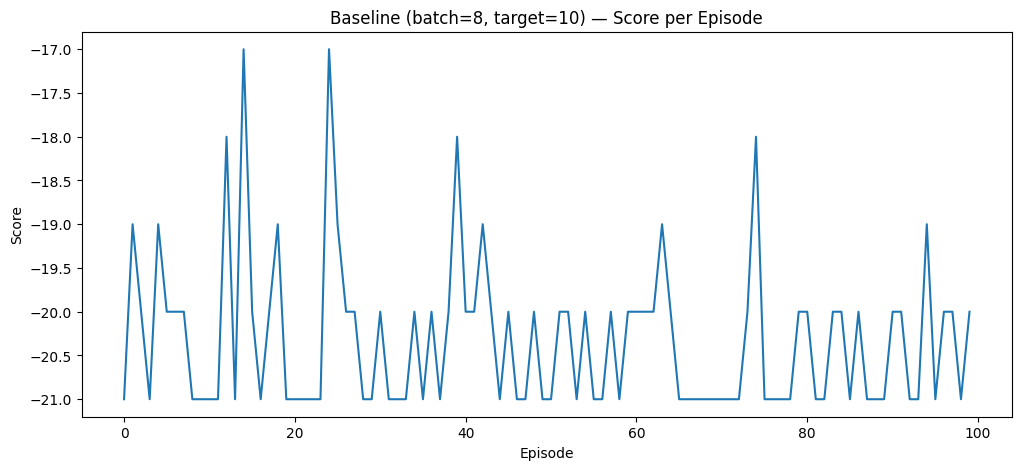

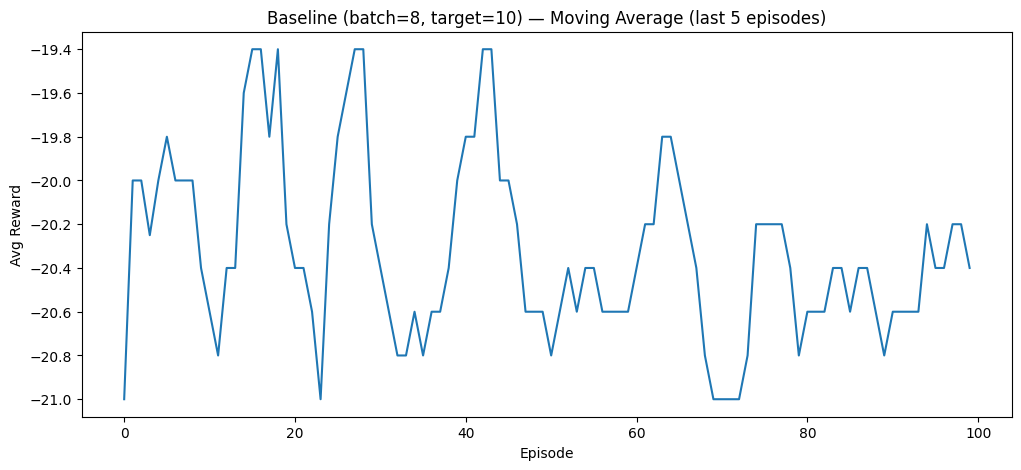

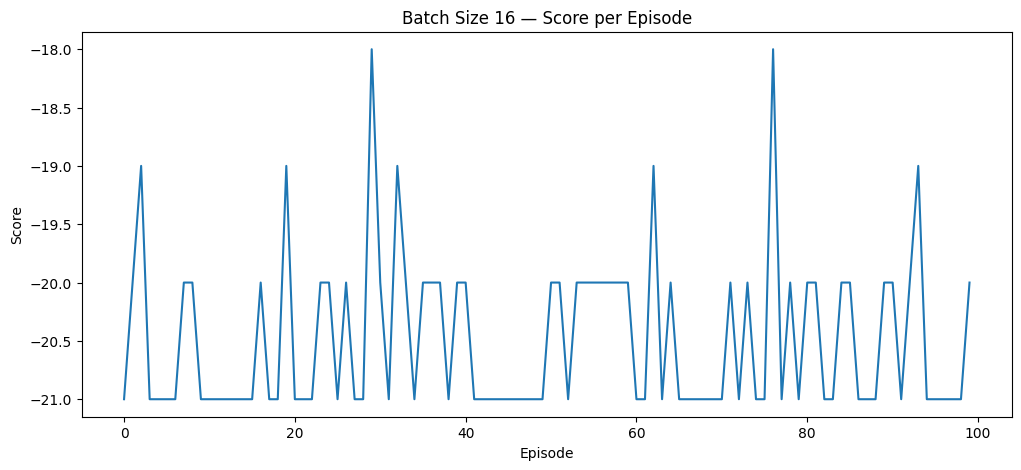

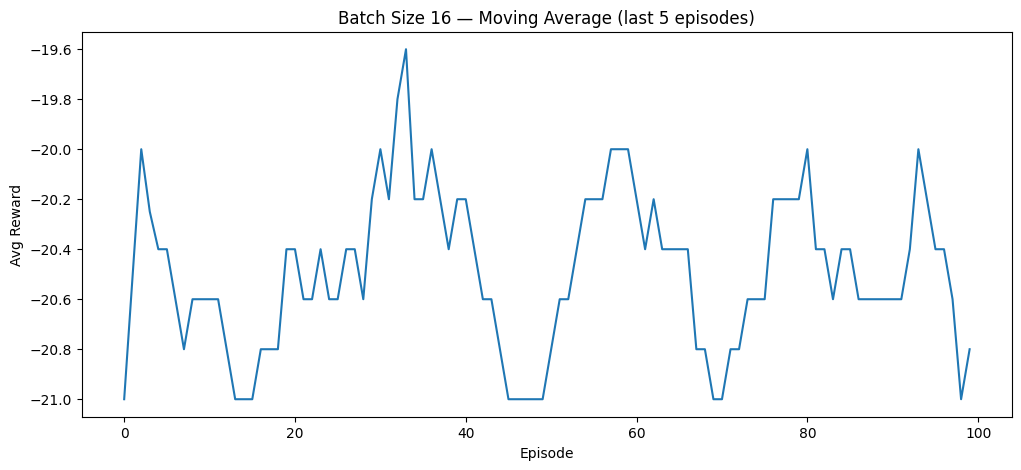

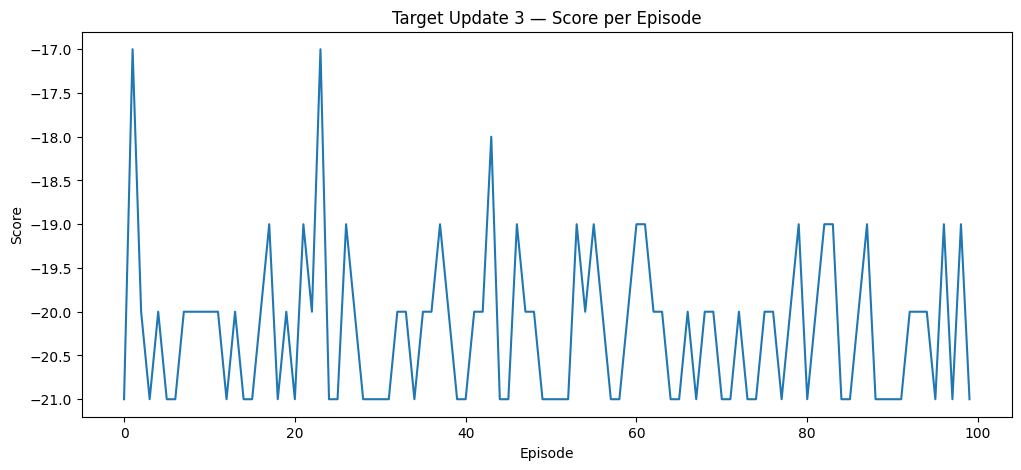

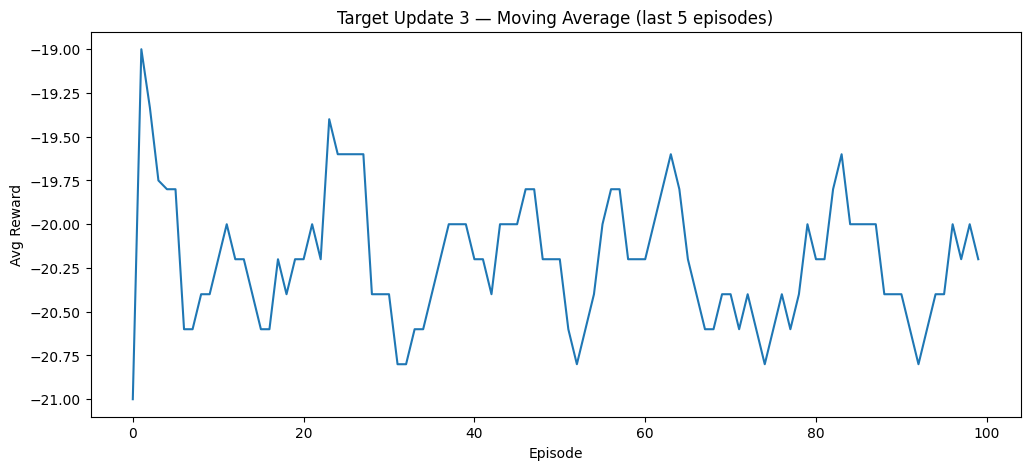

In [17]:
plot_results(scores_base, avg5_base, "Baseline (batch=8, target=10)")
plot_results(scores_b16, avg5_b16, "Batch Size 16")
plot_results(scores_tu3, avg5_tu3, "Target Update 3")


## Plotting All Experiment Results

To compare the performance of our different DQN training configurations, this section provides a set of visualization functions.  
These plots help analyze learning behavior, stability, and overall improvement across experiments.

### Plot Types Included:

#### **1. Score per Episode**
Shows raw episode rewards throughout training.  
Useful for identifying:
- Reward spikes  
- Instability or variance  
- How quickly each configuration begins improving  

#### **2. Moving Average (Last 5 Episodes)**
Smooths out episodic noise to show long-term trends.  
Helps highlight:
- Consistency in learning  
- Which configuration converges faster  
- Relative performance between experiments  

#### **3. Combined Score Comparison**
Overlays the score curves for:
- Baseline (Batch=8, Target=10)  
- Batch Size = 16  
- Target Update = 3  

This visual comparison helps determine which configuration yields better or more stable performance.

#### **4. Combined Moving Average Comparison**
Combines the smoothed 5-episode averages from all experiments.  
Useful for understanding:
- Overall training improvement  
- Stability and convergence  
- Best-performing hyperparameter setup  

These visualizations are essential for interpreting experiment outcomes and drawing conclusions for the final report.


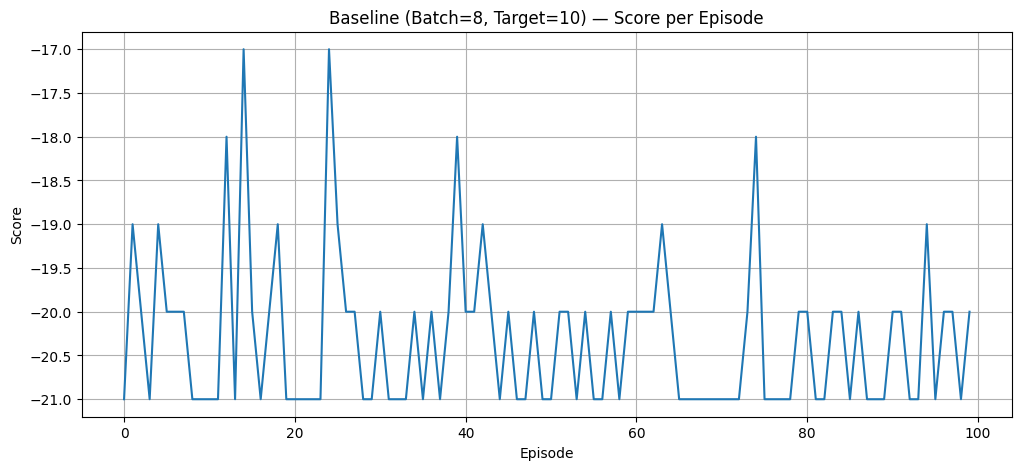

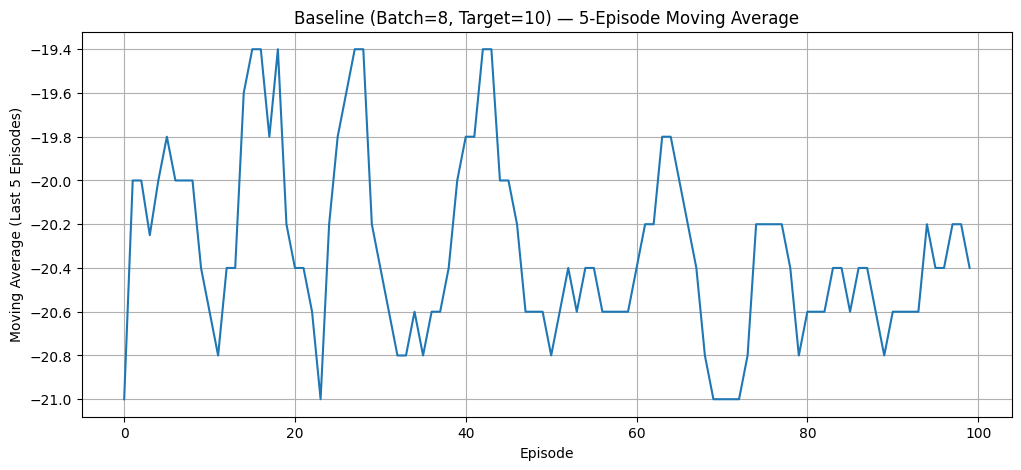

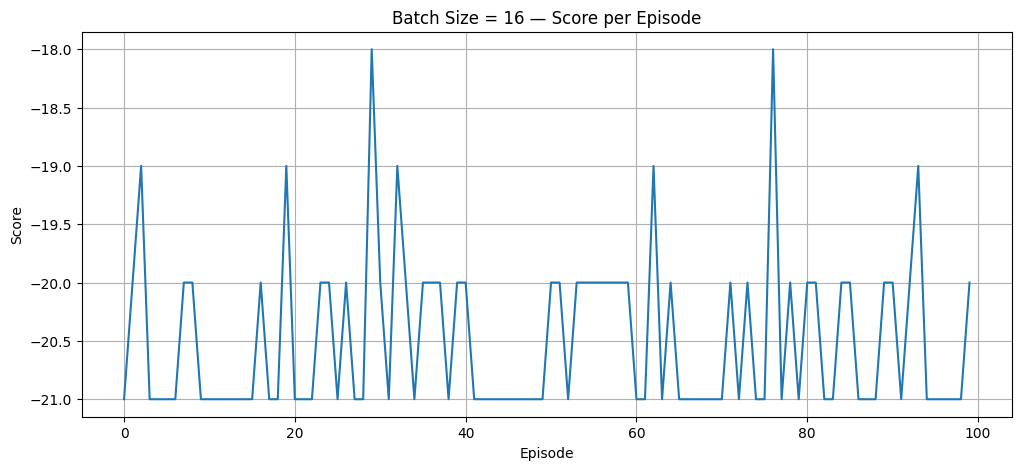

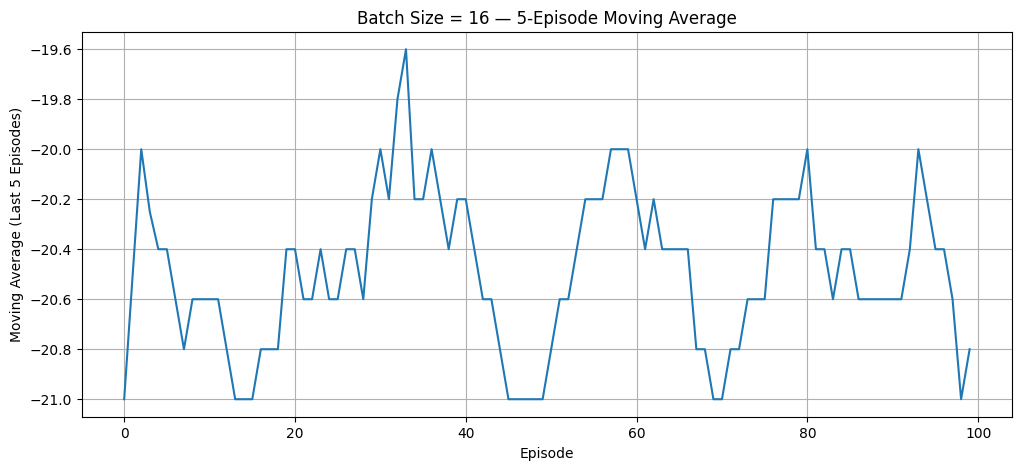

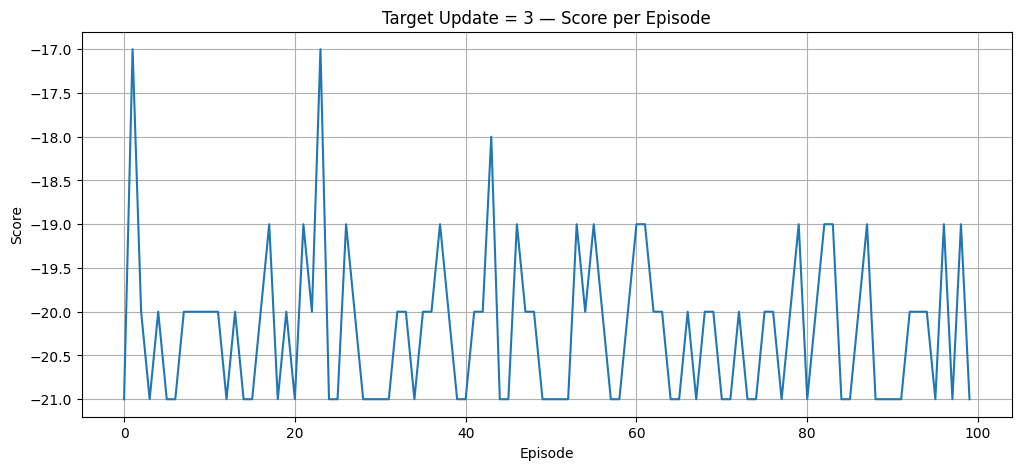

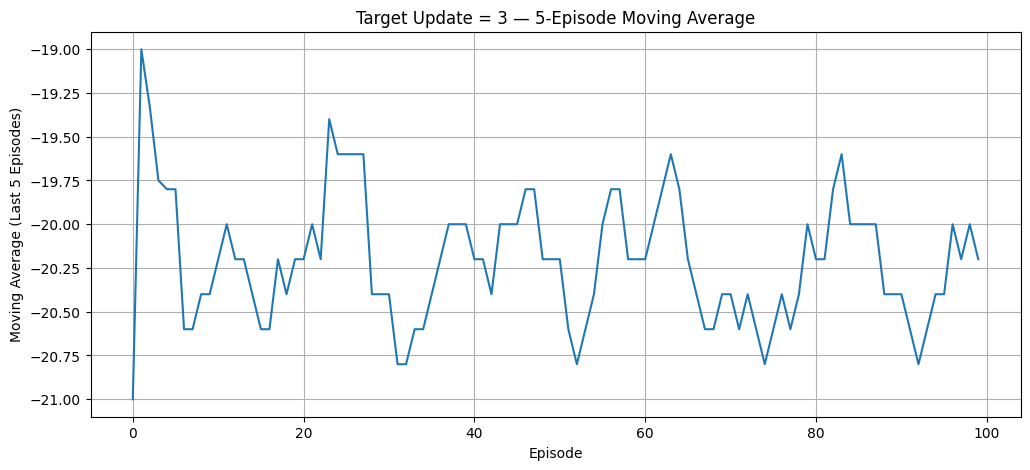

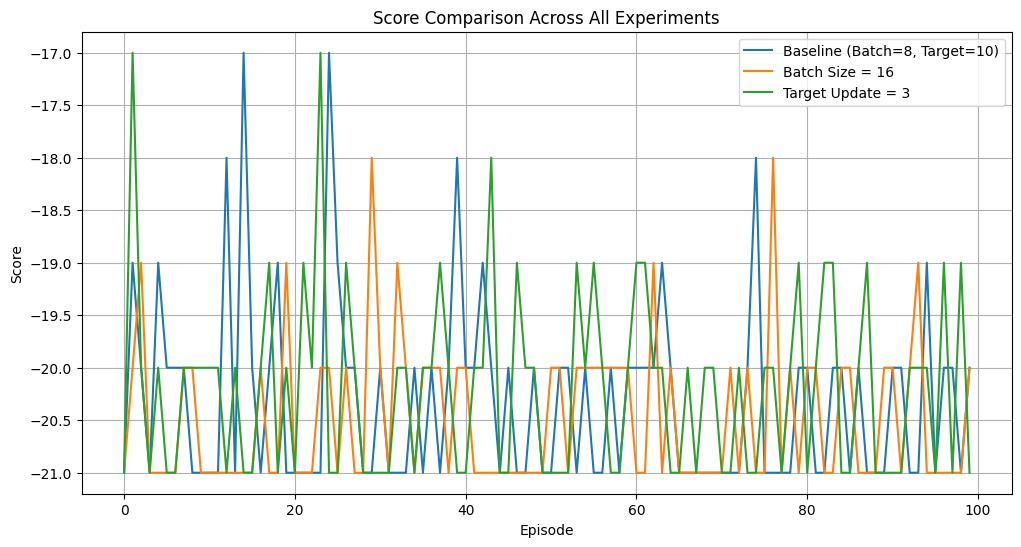

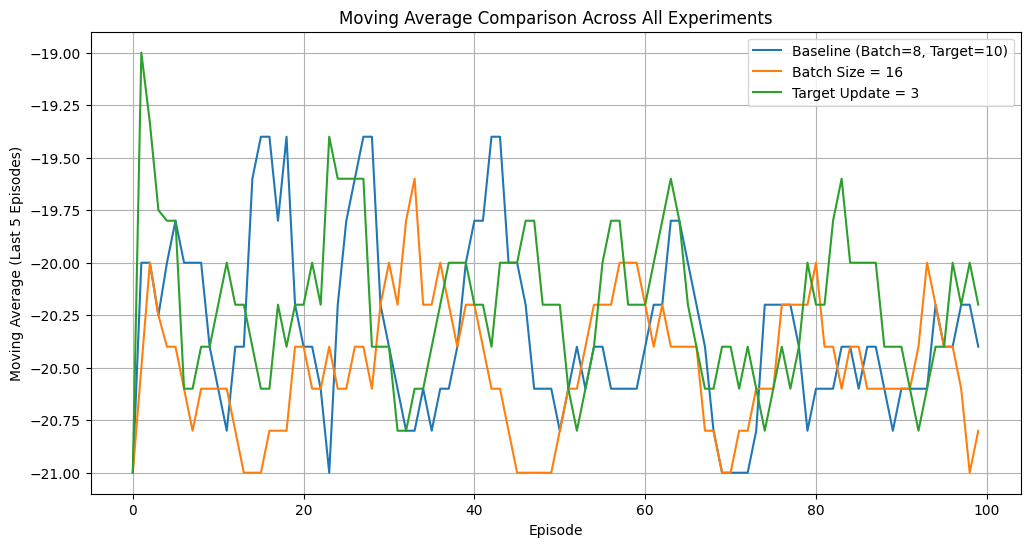

In [28]:
import matplotlib.pyplot as plt

# ==============================
# PLOTTING FUNCTIONS
# ==============================

def plot_score(scores, title):
    plt.figure(figsize=(12,5))
    plt.plot(scores)
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.title(f"{title} — Score per Episode")
    plt.grid(True)
    plt.show()

def plot_avg(avg5, title):
    plt.figure(figsize=(12,5))
    plt.plot(avg5)
    plt.xlabel("Episode")
    plt.ylabel("Moving Average (Last 5 Episodes)")
    plt.title(f"{title} — 5-Episode Moving Average")
    plt.grid(True)
    plt.show()

def plot_combined_scores(scores_base, scores_b16, scores_tu3):
    plt.figure(figsize=(12,6))
    plt.plot(scores_base, label="Baseline (Batch=8, Target=10)")
    plt.plot(scores_b16, label="Batch Size = 16")
    plt.plot(scores_tu3, label="Target Update = 3")
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.title("Score Comparison Across All Experiments")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_combined_avg(avg_base, avg_b16, avg_tu3):
    plt.figure(figsize=(12,6))
    plt.plot(avg_base, label="Baseline (Batch=8, Target=10)")
    plt.plot(avg_b16, label="Batch Size = 16")
    plt.plot(avg_tu3, label="Target Update = 3")
    plt.xlabel("Episode")
    plt.ylabel("Moving Average (Last 5 Episodes)")
    plt.title("Moving Average Comparison Across All Experiments")
    plt.legend()
    plt.grid(True)
    plt.show()


# ==============================
# GENERATE ALL REQUIRED PLOTS
# ==============================

# Individual experiment plots
plot_score(scores_base, "Baseline (Batch=8, Target=10)")
plot_avg(avg5_base, "Baseline (Batch=8, Target=10)")

plot_score(scores_b16, "Batch Size = 16")
plot_avg(avg5_b16, "Batch Size = 16")

plot_score(scores_tu3, "Target Update = 3")
plot_avg(avg5_tu3, "Target Update = 3")

# Combined comparison plots
plot_combined_scores(scores_base, scores_b16, scores_tu3)
plot_combined_avg(avg5_base, avg5_b16, avg5_tu3)
